<a href="https://colab.research.google.com/github/rus4787/Business-evaluation-of-the-clien/blob/main/%D0%9C%D0%B0%D1%80%D0%B8%D0%BD%D0%B0_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import plotly.express as px
import plotly.subplots as sp

In [ ]:
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)        # Игнорировать FutureWarning
warnings.simplefilter(action='ignore', category=DeprecationWarning)   # Игнорировать DeprecationWarning
warnings.simplefilter(action='ignore', category=SyntaxWarning)        # Игнорировать SyntaxWarning
warnings.simplefilter(action='ignore', category=RuntimeWarning)       # Игнорировать RuntimeWarning
warnings.simplefilter(action='ignore', category=UserWarning)          # Игнорировать UserWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# ОКВЭДы по клиентам кому продаем с Высоким ССД + регион

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/barnaul_analitic/base/data_SCHET.csv')
df_org = pd.read_csv('/content/drive/MyDrive/barnaul_analitic/base/df_organizations.csv')

<ipython-input-124-e05cf8b1092d>:1: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
data.head()

,идентификатор,номер_счета,номенклатура,тип_пакета,количество_удостоверений,цена_за_удостоверение,сумма,решение_об_оплате,номер_менеджера,фио_менеджера,инн_организации,наименование_организации,количество_студентов,тип_номенклатуры,код_номенклатуры,наименование_региона,расшифровка_оквэд,вид_деятельности,начало_работы,дата_изменения,год_начала,месяц_начала
0,65292821,38039332,173. Экология,NaN,1,0,0,оплачено,1153,Абдуразакова Елена Ивановна,1637003354,"МБДОУ ""ДЕТСКИЙ САД ""РАДУГА"" С.ЯМБУХТИНО""",1,по направлению,173,не установлен,не установлен,Не определено,2021-09-06 06:13:24,2021-09-06 06:13:24,2021,9
1,65293090,38039460,135. Обучение по охране труда,NaN,2,2233,4466,оплачено,1153,Абдуразакова Елена Ивановна,2437005476,"МКДОУ ДЕТСКИЙ САД ""ТЕРЕМОК""",2,по направлению,135,Красноярский край,Деятельность в области дошкольного образования,Образование,2021-09-06 06:14:13,2021-09-06 06:14:13,2021,9
2,65293130,38039477,173. Экология,NaN,1,0,0,оплачено,1153,Абдуразакова Елена Ивановна,5718004603,МБУ ЦК,1,по направлению,173,не установлен,не установлен,Не определено,2021-09-06 06:14:19,2021-09-06 06:14:19,2021,9
3,65294228,38039939,173. Экология,NaN,1,1000,1000,оплачено,1153,Абдуразакова Елена Ивановна,1328009253,"ООО ""ЖСК""",3,по направлению,173,Республика Мордовия,Управление недвижимым имуществом,Деятельность по операциям с недвижимым имуществом,2021-09-06 06:17:03,2021-09-06 06:17:03,2021,9
4,65294229,38039939,135. Обучение по охране труда,NaN,3,1000,3000,оплачено,1153,Абдуразакова Елена Ивановна,1328009253,"ООО ""ЖСК""",3,по направлению,135,Республика Мордовия,Управление недвижимым имуществом,Деятельность по операциям с недвижимым имуществом,2021-09-06 06:17:03,2021-09-06 06:17:03,2021,9


In [ ]:
data.shape

(248571, 22)

In [ ]:
def aggregate_by_years(data, years):
    def aggregate_data(df):
        # Шаг 1: Группировка по "номер счета"
        grouped_by_account = df.groupby('номер_счета').agg({
            'инн_организации': 'first',
            'наименование_организации': 'first',
            'сумма': 'sum',
            'решение_об_оплате': 'last',
            'наименование_региона': 'first',
            'расшифровка_оквэд': 'first',
            'вид_деятельности': 'first',
            'начало_работы': 'first'
        }).reset_index()

        # Шаг 2: Группировка по "инн_организации"
        result = grouped_by_account.groupby('инн_организации').agg({
            'наименование_региона': 'first',
            'расшифровка_оквэд': 'first',
            'вид_деятельности': 'first',
            'номер_счета': 'count',
            'решение_об_оплате': lambda x: (x == 'оплачено').sum(),
            'сумма': ['mean', 'min', 'max']
        }).reset_index()

        # Переименовываем столбцы для удобства
        result.columns = ['инн_организации', 'наименование_региона', 'расшифровка_оквэд', 'вид_деятельности',
                          'количество_счетов', 'количество_сделок', 'средняя_сумма', 'минимальная_сумма', 'максимальная_сумма']

        return result

    final_result = pd.DataFrame()

    for year in years:
        # Разбиваем данные по годам
        df_year = data[data['год_начала'] == year]
        df_year['год'] = year  # Добавляем столбец с годом

        # Агрегируем данные для каждого года
        aggregated_year = aggregate_data(df_year)
        aggregated_year['год'] = year  # Добавляем столбец с годом в результат

        # Объединяем результаты
        final_result = pd.concat([final_result, aggregated_year], ignore_index=True)

    return final_result

In [ ]:
years = [2021, 2022, 2023, 2024]
result = aggregate_by_years(data, years)

In [ ]:
result = result.merge(df_org[['инн', 'оквэд']], left_on='инн_организации', right_on='инн', how='left')
result = result[result['инн_организации'] != 0]
result = result[result['количество_сделок'] != 0]
result = result.sort_values(by=['год', 'средняя_сумма'], ascending=False)

✅ **Для Марины**

В итоге работатем с таблицей где: только счета с оплатой, ИНН не равно 0

In [ ]:
result.head()

,инн_организации,наименование_региона,расшифровка_оквэд,вид_деятельности,количество_счетов,количество_сделок,средняя_сумма,минимальная_сумма,максимальная_сумма,год,инн,оквэд
48794,268003446,Республика Башкортостан,"Производство хлеба и мучных кондитерских изделий, тортов и пирожных недлительного хранения",Обрабатывающие производства,1,1,405000.0,405000,405000,2024,2.680034e+08,10.71
49586,2201000766,Алтайский край,Производство продуктов мукомольно-крупяной промышленности,Обрабатывающие производства,1,1,405000.0,405000,405000,2024,2.201001e+09,10.61
54022,7450003519,Челябинская область,Деятельность воздушного транспорта в сфере грузовых перевозок,Транспортировка и хранение,1,1,405000.0,405000,405000,2024,7.450004e+09,51.10
50713,2828007739,Амурская область,Строительство зданий,Строительство,2,2,355500.0,306000,405000,2024,2.828008e+09,41.20
50235,2457051576,Красноярский край,Деятельность городского и пригородного пассажирского транспорта,Транспортировка и хранение,1,1,306000.0,306000,306000,2024,2.457052e+09,49.31


In [ ]:
result.to_excel('/content/drive/MyDrive/barnaul_analitic/analitic_product/марина_орган_ССД_по годам.xlsx', index=False)

In [ ]:
org_count_by_year = result.groupby('год').size().reset_index(name='количество_организаций')

# Строим график с использованием plotly.express
fig = px.bar(org_count_by_year, x='год', y='количество_организаций',
             title='Количество организаций по годам',
             labels={'год': 'Год', 'количество_организаций': 'Количество организаций'})

fig.update_layout(xaxis_title='Год', yaxis_title='Количество организаций')
fig.show()

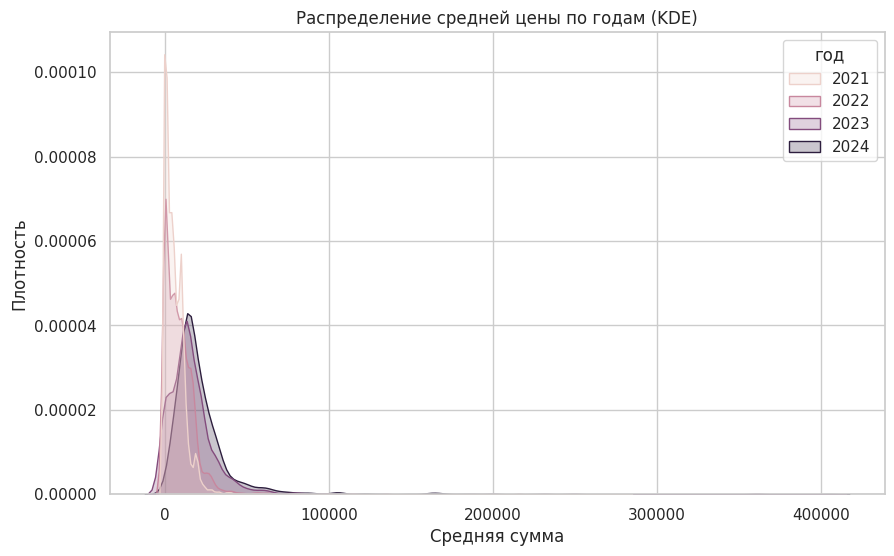

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=result, x='средняя_сумма', hue='год', fill=True, common_norm=False)
plt.title('Распределение средней цены по годам (KDE)')
plt.xlabel('Средняя сумма')
plt.ylabel('Плотность')
plt.show()

Максимальное количество чеков до 20000 рублей. Разобьем по диапозонам до 100к, от 100к до 300к, и более 300к

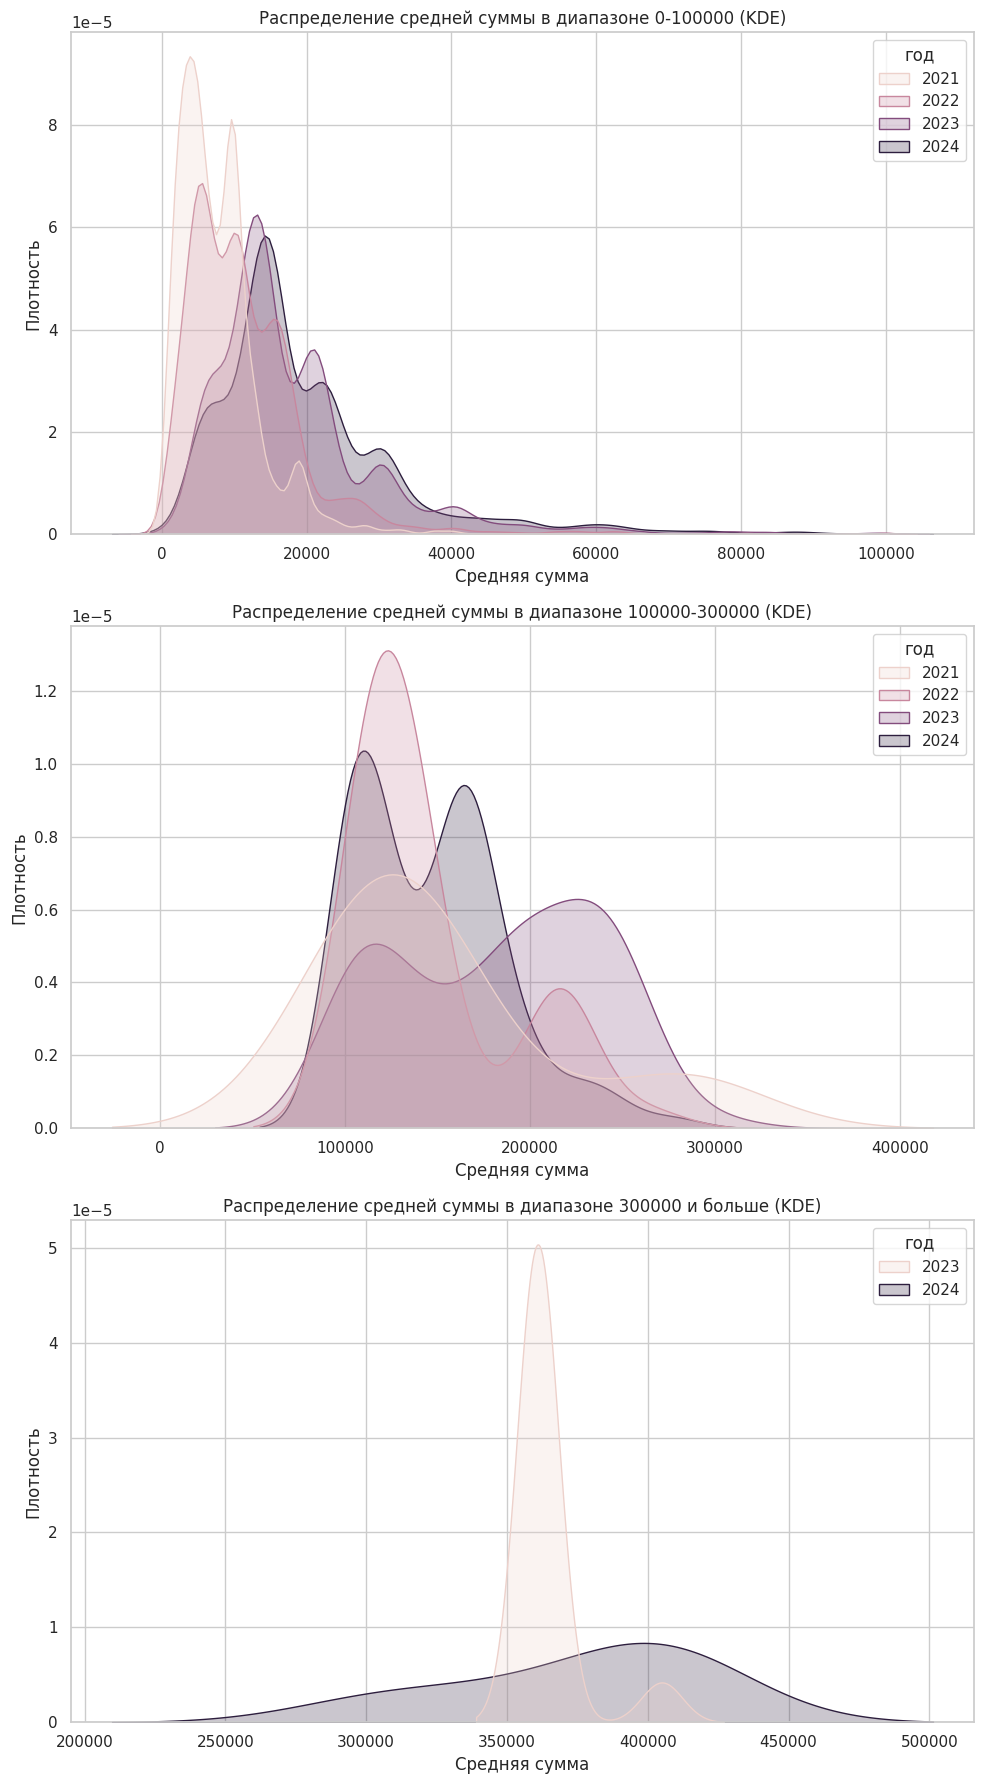

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Диапазоны для разбиения
bins = [0, 100000, 300000, float('inf')]
labels = ['0-100000', '100000-300000', '300000 и больше']
# столбец для категоризации по диапазонам
result['диапазон'] = pd.cut(result['средняя_сумма'], bins=bins, labels=labels)

# графики KDE для каждого диапазона
for i, label in enumerate(labels):
    ax = axes[i]
    subset = result[result['диапазон'] == label]
    sns.kdeplot(data=subset, x='средняя_сумма', hue='год', fill=True, common_norm=False, ax=ax)
    ax.set_title(f'Распределение средней суммы в диапазоне {label} (KDE)')
    ax.set_xlabel('Средняя сумма')
    ax.set_ylabel('Плотность')

plt.tight_layout()
plt.show()

In [ ]:
result_23_24 = result[result['год'] > 2022]

✅ **Для Марины**

Теепрь только для 2023 и 2024 год. и Для организаций которрые сделали более 2 заказов

In [ ]:
result_2 = result_23_24[result_23_24['количество_сделок']> 1]

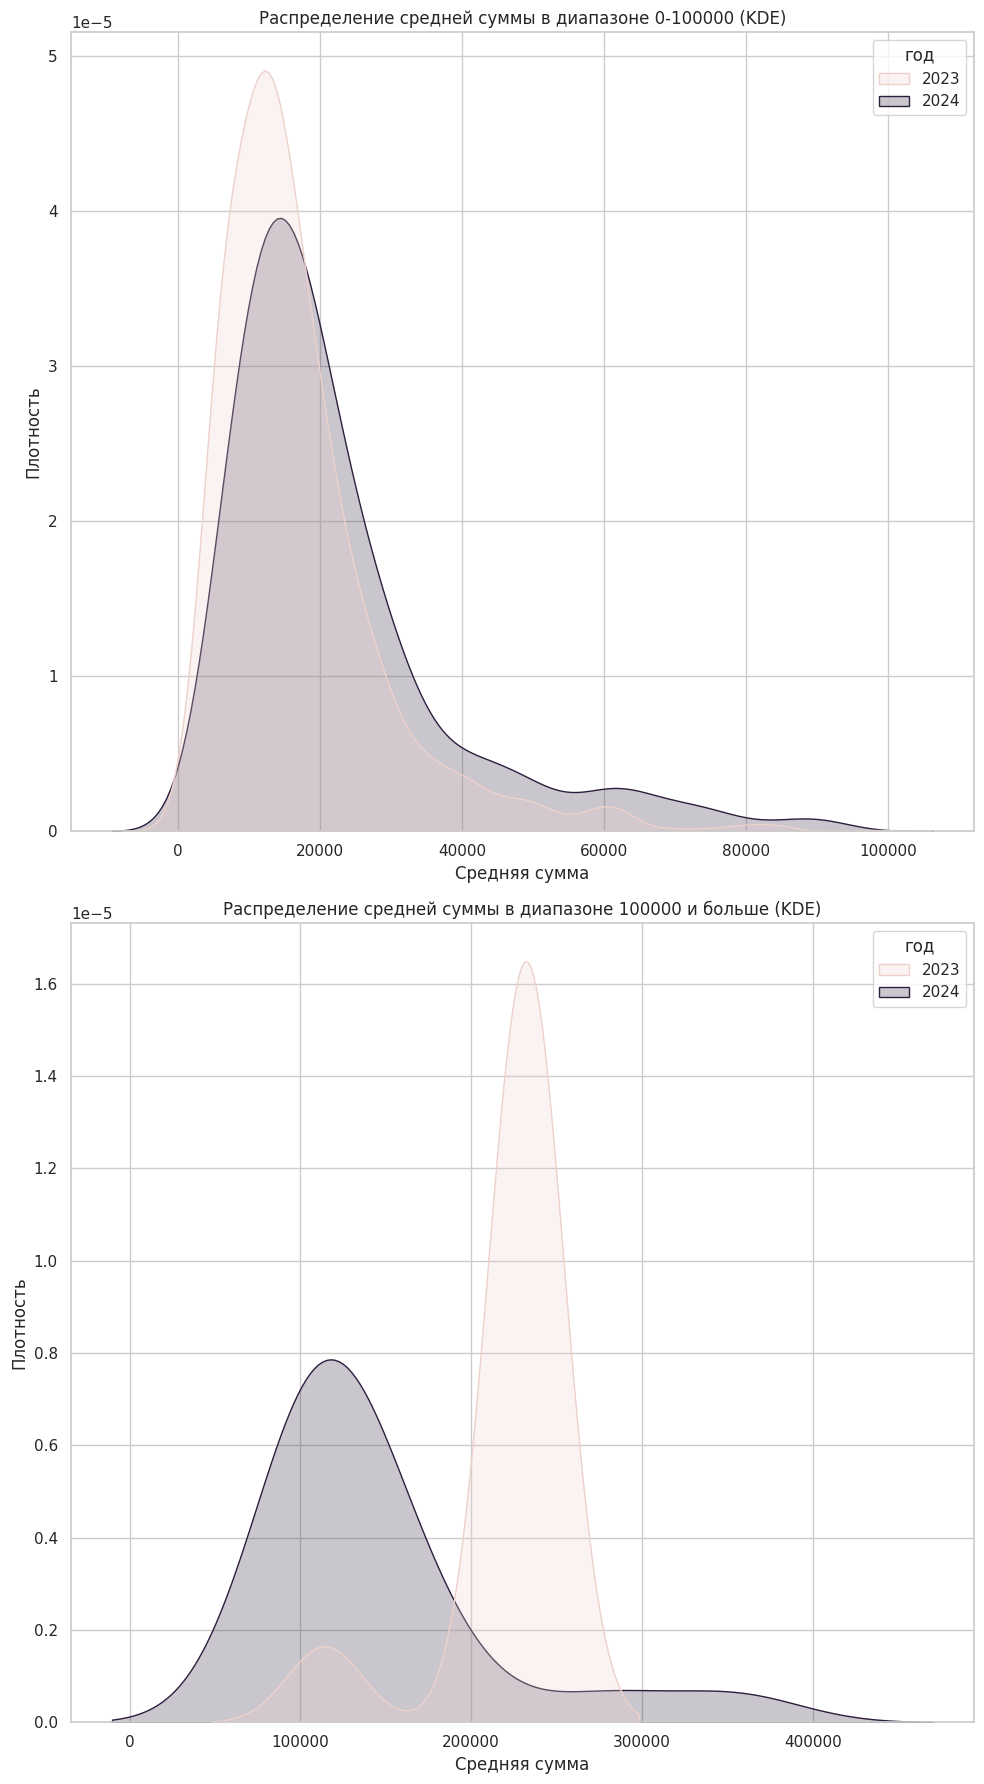

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(10, 18))

# Диапазоны для разбиения
bins = [0, 100000, float('inf')]
labels = ['0-100000', '100000 и больше']
# столбец для категоризации по диапазонам
result_2['диапазон'] = pd.cut(result_2['средняя_сумма'], bins=bins, labels=labels)

# графики KDE для каждого диапазона
for i, label in enumerate(labels):
    ax = axes[i]
    subset = result_2[result_2['диапазон'] == label]
    sns.kdeplot(data=subset, x='средняя_сумма', hue='год', fill=True, common_norm=False, ax=ax)
    ax.set_title(f'Распределение средней суммы в диапазоне {label} (KDE)')
    ax.set_xlabel('Средняя сумма')
    ax.set_ylabel('Плотность')

plt.tight_layout()
plt.show()

✅ **Для Марины**

Обрати внимание - все чеки больше 350к отлетели - значит это разовый харрактер.

смотрим по количеству заказов

In [ ]:
counts = result_23_24['количество_сделок'].value_counts()
percentages = result_23_24['количество_сделок'].value_counts(normalize=True) * 100
result_4 = pd.DataFrame({'Количество': counts, 'Проценты': percentages})
result_4

,Количество,Проценты
количество_сделок,,
1,14471,82.800252
2,2335,13.360417
3,484,2.769354
4,119,0.680895
5,41,0.234594
6,14,0.080105
7,6,0.034331
8,4,0.022887
11,2,0.011444


теперь только 2024 год

In [ ]:
result_2024 = result_23_24[result_23_24['год'] == 2024]
counts = result_2024['количество_сделок'].value_counts()
percentages = result_2024['количество_сделок'].value_counts(normalize=True) * 100
result_5 = pd.DataFrame({'Количество': counts, 'Проценты': percentages})
result_5

,Количество,Проценты
количество_сделок,,
1,5303,87.163051
2,623,10.239974
3,125,2.054569
4,23,0.378041
5,7,0.115056
10,1,0.016437
7,1,0.016437
8,1,0.016437


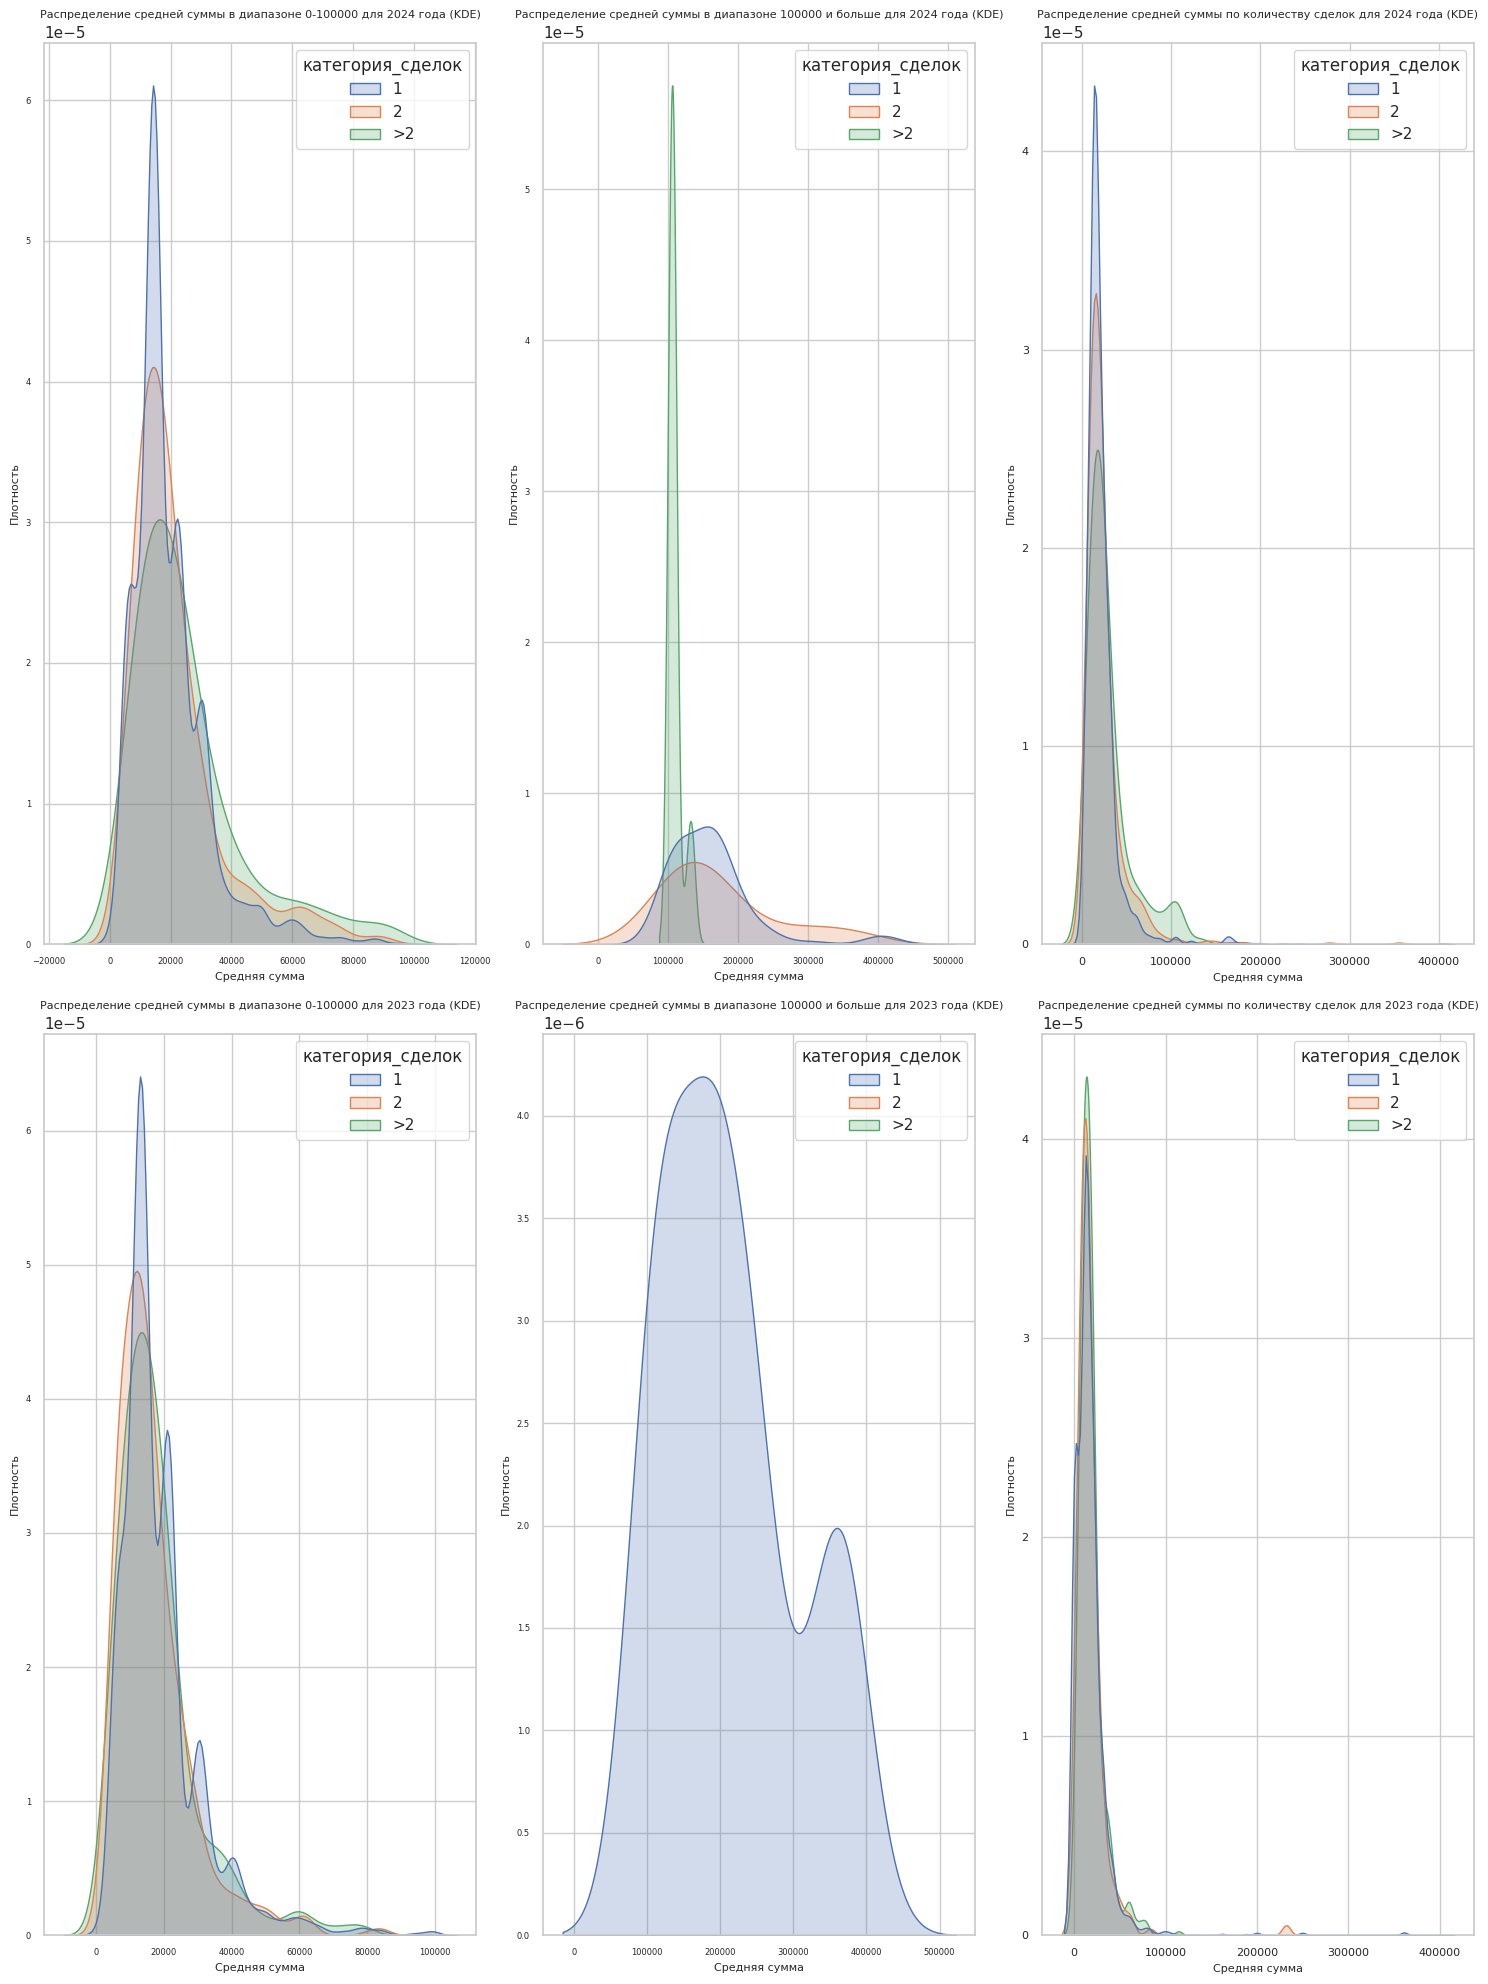

In [ ]:
bins = [0, 100000, float('inf')]
labels = ['0-100000', '100000 и больше']

# Устанавливаем стиль
sns.set(style="whitegrid")

# Создаем подграфики для каждого года
years = result_23_24['год'].unique()
fig, axes = plt.subplots(len(years), 3, figsize=(15, 10 * len(years)))

for j, year in enumerate(years):
    subset_year = result_23_24[result_23_24['год'] == year]
    subset_year['категория_сделок'] = pd.cut(subset_year['количество_сделок'], bins=[-1, 1, 2, float('inf')], labels=['1', '2', '>2'])
    subset_year['диапазон'] = pd.cut(subset_year['средняя_сумма'], bins=bins, labels=labels)

    for i, label in enumerate(labels):
        ax = axes[j, i]
        subset = subset_year[subset_year['диапазон'] == label]
        sns.kdeplot(data=subset, x='средняя_сумма', hue='категория_сделок', fill=True, common_norm=False, ax=ax)
        ax.set_title(f'Распределение средней суммы в диапазоне {label} для {year} года (KDE)', fontsize=8)
        ax.set_xlabel('Средняя сумма', fontsize=8)
        ax.set_ylabel('Плотность', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

    # Добавляем график для общего распределения по количеству сделок
    ax = axes[j, 2]
    sns.kdeplot(data=subset_year, x='средняя_сумма', hue='категория_сделок', fill=True, common_norm=False, ax=ax)
    ax.set_title(f'Распределение средней суммы по количеству сделок для {year} года (KDE)', fontsize=8)
    ax.set_xlabel('Средняя сумма', fontsize=8)
    ax.set_ylabel('Плотность', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

✅ **Для Марины**

Обрати внимание:
- 2023 год - все чеки больше 100к - это разовый харрактер.
- 2024 год - все что 150к+ носит либо разовый либо повторный характер.

Но разовые сделки преобладают везде: 14471 организаций (79% от общего количества) сделали по 1 заказу.

In [ ]:
group_result_23_24 = result_23_24.groupby('инн_организации').agg({
    'наименование_региона': 'first',
    'оквэд': 'first',
    'расшифровка_оквэд': 'first',
    'вид_деятельности': 'first',
    'количество_счетов': 'sum',
    'количество_сделок': 'sum',
    'средняя_сумма': ['mean', 'min', 'max']
}).reset_index()

In [ ]:
group_result_23_24.columns = ['инн_организации', 'наименование_региона', 'оквэд', 'расшифровка_оквэд',
                              'вид_деятельности',  'количество_счетов', 'количество_сделок',
                              'средняя_сумма', 'минимальная_сумма', 'максимальная_сумма']

In [ ]:
group_result_23_24

,инн_организации,наименование_региона,оквэд,расшифровка_оквэд,вид_деятельности,количество_счетов,количество_сделок,средняя_сумма,минимальная_сумма,максимальная_сумма
0,100000220,Республика Адыгея,86.23,Деятельность специализированных медицинских учреждений,Деятельность в области здравоохранения и социальных услуг,1,1,13000.000000,13000.0,13000.000000
1,101002156,Республика Адыгея,86.10,Деятельность больничных организаций,Деятельность в области здравоохранения и социальных услуг,1,1,5000.000000,5000.0,5000.000000
2,101004611,Республика Адыгея,01.11,"Выращивание зерновых культур (кроме риса), бобовых культур и семян масличных культур","Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",5,5,19752.916667,14197.5,25308.333333
3,101005380,Республика Адыгея,01.1,Выращивание однолетних культур,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",3,3,32933.000000,23866.0,42000.000000
4,101005527,Республика Адыгея,84.11,"Деятельность органов государственного управления, связанная с общегосударственным управлением",Государственное управление и оборона; обязательное социальное обеспечение,1,1,19992.000000,19992.0,19992.000000
...,...,...,...,...,...,...,...,...,...,...
15259,910800060507,Республика Крым,49.39,"Деятельность прочего сухопутного пассажирского транспорта, не включенная в другие группировки",Транспортировка и хранение,1,1,7000.000000,7000.0,7000.000000
15260,911001055679,Республика Крым,None,не установлен,Не определено,1,1,7565.000000,7565.0,7565.000000
15261,2501016911253,не установлен,None,не установлен,Не определено,1,1,16100.000000,16100.0,16100.000000
15262,3823032700369,Иркутская область,None,не установлен,Не определено,1,1,0.000000,0.0,0.000000


In [ ]:
group_result_23_24.to_excel('/content/drive/MyDrive/barnaul_analitic/analitic_product/марина_орган_ССД_слитый.xlsx', index=False)

# Окведы с максимальными чеками

In [ ]:
pivot_table = group_result_23_24.pivot_table(index='оквэд',
                             values=['количество_сделок', 'средняя_сумма', 'минимальная_сумма', 'максимальная_сумма'],
                             aggfunc={'количество_сделок': 'sum',
                                      'средняя_сумма': lambda x: round(x.mean(), 1),
                                      'минимальная_сумма': 'min',
                                      'максимальная_сумма': 'max'})


pivot_table_1 = pivot_table[pivot_table['средняя_сумма'] > 25000].sort_values(by='средняя_сумма', ascending=False)
pivot_table_1 = pivot_table_1.reset_index()
pivot_table_1.head(10)

,оквэд,количество_сделок,максимальная_сумма,минимальная_сумма,средняя_сумма
0,46.15,10,250000.0,250000.0,250000.0
1,13.94,1,122400.0,122400.0,122400.0
2,27.11,3,200000.0,45600.0,122366.7
3,20.13,7,243200.0,36541.0,89708.0
4,46.19,1,87500.0,87500.0,87500.0
5,27.90,2,85500.0,85500.0,85500.0
6,05.20,2,83000.0,83000.0,83000.0
7,23.6,2,150000.0,0.0,75000.0
8,26.30,4,76000.0,45250.0,65516.7
9,23.13,2,105250.0,13500.0,59375.0


Строим  два графика в plotly express: ТОП-20 оквэд по средняя_сумма, и ТОП-20 оквэд по максимальная_сумма

In [ ]:
top_20_avg = pivot_table_1.nlargest(20, 'средняя_сумма')
top_20_max = pivot_table_1.nlargest(20, 'максимальная_сумма')
# График для ТОП-20 по средней сумме
fig_avg = px.bar(top_20_avg, x='оквэд', y='средняя_сумма', title='ТОП-20 ОКВЭД по средней сумме')
fig_avg.update_layout(xaxis_title='ОКВЭД', yaxis_title='Средняя сумма')
# График для ТОП-20 по максимальной сумме
fig_max = px.bar(top_20_max, x='оквэд', y='максимальная_сумма', title='ТОП-20 ОКВЭД по максимальной сумме')
fig_max.update_layout(xaxis_title='ОКВЭД', yaxis_title='Максимальная сумма')

fig_avg.show()
fig_max.show()

А теперь соединим ТОП-10 ОКВЭД

In [ ]:
top_10_avg = pivot_table_1.nlargest(10, 'средняя_сумма')
top_10_max = pivot_table_1.nlargest(10, 'максимальная_сумма')
fig = sp.make_subplots(rows=2, cols=1, subplot_titles=('ТОП-10 ОКВЭД по средней сумме', 'ТОП-10 ОКВЭД по максимальной сумме'))
fig.add_trace(px.bar(top_10_avg, x='оквэд', y='средняя_сумма').data[0], row=1, col=1)
fig.add_trace(px.bar(top_10_max, x='оквэд', y='максимальная_сумма').data[0], row=2, col=1)
fig.update_xaxes(title_text='ОКВЭД', row=1, col=1)
fig.update_yaxes(title_text='Средняя сумма', row=1, col=1)
fig.update_xaxes(title_text='ОКВЭД', row=2, col=1)
fig.update_yaxes(title_text='Максимальная сумма', row=2, col=1)

fig.update_layout(title_text='ТОП-10 ОКВЭД по средней и максимальной сумме', showlegend=False)
fig.show()

In [ ]:
pivot_table_1.to_excel('/content/drive/MyDrive/barnaul_analitic/analitic_product/Окведы_с_макс_средним_чеками.xlsx', index=False)

# Окведы по регионам

In [ ]:
regional_okved = group_result_23_24.groupby('наименование_региона')['оквэд'].apply(lambda x: ','.join(x.value_counts().head(20).index)).reset_index()
regional_okved.head(20)

,наименование_региона,оквэд
0,Алтайский край,"01.11,84.11,85.14,86.10,85.41,01.50,85.11,75.00,35.30,85.13,01.41,87.90,68.32,68.20,85.21,47.11,36.00,01.1,10.71,47.1"
1,Амурская область,"84.11,85.14,01.11,07.29,68.32,87.90,85.41,85.11,41.20,35.30,85.13,87.30,91.04,86.23,86.10,02.10,75.00,02.20,91.01,46.73"
2,Архангельская область,"85.14,84.11,85.11,35.30,68.32,85.13,86.23,90.04,87.90,47.11,85.21,91.01,16.10,93.19,01.41,02.20,85.41,68.20,75.00,42.11"
3,Астраханская область,"84.11,85.14,85.11,85.13,75.00,86.10,79.11,86.90,68.32,03.12,35.30,52.22,52.21,36.00,37.00,59.14,90.04,96.02,55.90,10.71"
4,Белгородская область,"84.11,01.11,87.90,85.14,86.23,85.13,01.47,68.20,85.41,46.71,85.11,94.99,01.41,41.2,85.42,90.01,55.10,63.11,47.30,86.90"
5,Брянская область,"84.11,85.14,85.13,36.00,47.11,20.15,94.91,85.11,01.41,86.10,85.41,93.29,22.23,01.11,16.23,47.25,46.34,35.30,42.11,28.30"
6,Владимирская область,"85.14,85.11,87.90,85.13,86.10,84.11,36.00,02.20,68.32,01.41,91.01,85.21,85.41,86.90,49.39,72.19,01.46,23.12,94.91,01.11"
7,Волгоградская область,"84.11,01.11,85.14,68.32,85.13,90.04,81.29,75.00,91.01,85.11,52.10,90.01,36.00,86.10,86.23,38.11,28.1,23.6,68.20,45.1"
8,Вологодская область,"01.41,85.14,68.20,02.20,85.13,84.11,91.01,35.30,16.10,86.23,47.78,10.13,01.4,68.32,85.41,85.11,47.2,36.00,28.29,45.20"
9,Воронежская область,"84.11,01.11,85.14,85.11,86.10,75.00,85.13,49.31,35.30,68.32,87.90,47.11,85.21,87.30,86.23,84.25,41.20,20.16,47.73,46.69"


Проанализируем таблицу из п.1 и из п.2 - отберем 10 регионов в которых преобладают ОКВЕД с максимальными средними чеками. Выведем в таблице: регион, ОКВЕД (каждый оквед отдельно в столбец) с максимальным чеком по ним для этого региона

In [ ]:
top_okved_regions = pivot_table_1.nlargest(40, 'средняя_сумма')['оквэд'].tolist()

regional_okved['top_okved'] = regional_okved['оквэд'].apply(lambda x: [okved for okved in x.split(',') if okved in top_okved_regions])
filtered_regions = regional_okved[regional_okved['top_okved'].apply(len) > 0]

result_1 = filtered_regions.explode('top_okved').merge(group_result_23_24, left_on=['наименование_региона', 'top_okved'], right_on=['наименование_региона', 'оквэд'])
result_1 = result_1.groupby(['наименование_региона', 'top_okved']).agg({'средняя_сумма': 'max'}).reset_index()

In [ ]:
result_1

,наименование_региона,top_okved,средняя_сумма
0,Амурская область,07.29,50000.000000
1,Брянская область,16.23,13730.000000
2,Брянская область,20.15,79380.000000
3,Владимирская область,01.46,50000.000000
4,Волгоградская область,23.6,150000.000000
5,Забайкальский край,07.29,27797.000000
6,Карачаево-Черкесская Республика,94.12,36000.000000
7,Кировская область,52.23,21995.000000
8,Курганская область,10.61,22008.000000
9,Магаданская область,07.29,298183.000000


Построим графикдля для ТОП-10 регионов по максимальная "средняя_сумма" и соответствующий 'top_okved'

In [ ]:
top_20_regions = result_1.nlargest(20, 'средняя_сумма')

fig = px.bar(top_20_regions, x='наименование_региона', y='средняя_сумма', text='top_okved',
             title='ТОП-20 регионов по максимальной "средняя_сумма" с указанием top_okved')

fig.update_xaxes(title_text='Регион')
fig.update_yaxes(title_text='Максимальная средняя сумма')

fig.update_layout(showlegend=False)
fig.show()

In [ ]:
result_1.to_excel('/content/drive/MyDrive/barnaul_analitic/analitic_product/Регионы_с_макс_Оквед.xlsx', index=False)

# Окведы со средним чеком более 25 000 рублей

In [ ]:
def group_result(result, num):
    years = [2023, 2024]
    grouped_results = {}
    result = result[result['средняя_сумма'] > num]

    for year in years:
        group_result_year = result[result['год'] == year].groupby('инн_организации').agg({
            'наименование_региона': 'first',
            'оквэд': 'first',
            'расшифровка_оквэд': 'first',
            'вид_деятельности': 'first',
            'количество_счетов': 'sum',
            'количество_сделок': 'sum',
            'средняя_сумма': ['mean', 'min', 'max']
        }).reset_index()

        group_result_year.columns = ['инн_организации', 'наименование_региона', 'оквэд', 'расшифровка_оквэд',
                                     'вид_деятельности', 'количество_счетов', 'количество_сделок',
                                     'средняя_сумма', 'минимальная_сумма', 'максимальная_сумма']

        grouped_results[year] = group_result_year

    return grouped_results

In [ ]:
grouped_results = group_result(result, 25000)

high_avg_check_23 = grouped_results[2023]
high_avg_check_24 = grouped_results[2024]

# ОКВЭД и году, если есть столбец с годом
high_avg_check_grouped_23 = high_avg_check_23.groupby(['оквэд', 'расшифровка_оквэд', 'вид_деятельности']).agg({
    'средняя_сумма': lambda x: round(x.mean(), 1),
    'минимальная_сумма': lambda x: round(x.min(), 1),
    'максимальная_сумма': lambda x: round(x.max(), 1),
    'количество_сделок': 'sum',
    'наименование_региона': lambda x: x.value_counts().idxmax()
}).reset_index().sort_values(by='средняя_сумма', ascending=False)

high_avg_check_grouped_24 = high_avg_check_24.groupby(['оквэд', 'расшифровка_оквэд', 'вид_деятельности']).agg({
    'средняя_сумма': lambda x: round(x.mean(), 1),
    'минимальная_сумма': lambda x: round(x.min(), 1),
    'максимальная_сумма': lambda x: round(x.max(), 1),
    'количество_сделок': 'sum',
    'наименование_региона': lambda x: x.value_counts().idxmax()
}).reset_index().sort_values(by='средняя_сумма', ascending=False)


# ТОП-10 для каждого года
top_20_2023 = high_avg_check_grouped_23.head(20)
top_20_2024 = high_avg_check_grouped_24.head(20)

In [ ]:
top_20_2023

,оквэд,расшифровка_оквэд,вид_деятельности,средняя_сумма,минимальная_сумма,максимальная_сумма,количество_сделок,наименование_региона
129,46.15,не установлен,Не определено,250000.0,250000.0,250000.0,10,Республика Крым
1,01.1,не установлен,Не определено,99452.0,99452.0,99452.0,4,Оренбургская область
186,71.12,Деятельность в области инженерно-технического проектирования,"Деятельность профессиональная, научная и техническая",94070.0,94070.0,94070.0,1,г. Санкт-Петербург
83,27.90,Производство прочего электрического оборудования,Обрабатывающие производства,85500.0,85500.0,85500.0,2,Липецкая область
21,03.21,не установлен,Не определено,84354.0,84354.0,84354.0,4,Сахалинская область
23,05.20,Добыча и обогащение бурого угля (лигнита),Добыча полезных ископаемых,83000.0,83000.0,83000.0,2,Приморский край
68,24.10,"Производство чугуна, стали и ферросплавов",Обрабатывающие производства,78625.0,78625.0,78625.0,1,Краснодарский край
57,20.15,Производство удобрений и азотных соединений,Обрабатывающие производства,73886.6,68393.2,79380.0,9,Брянская область
137,46.73,"Торговля оптовая лесоматериалами, строительными материалами и санитарно-техническим оборудованием",Торговля оптовая и розничная; ремонт автотранспортных средств и мотоциклов,71332.7,25998.0,162000.0,10,Республика Марий Эл
25,07.29,Добыча и обогащение руд прочих цветных металлов,Добыча полезных ископаемых,71189.6,26150.0,298183.0,18,Магаданская область


In [ ]:
top_20_2024

,оквэд,расшифровка_оквэд,вид_деятельности,средняя_сумма,минимальная_сумма,максимальная_сумма,количество_сделок,наименование_региона
51,20.13,Производство прочих основных неорганических химических веществ,Обрабатывающие производства,243200.0,243200.0,243200.0,1,Новосибирская область
9,01.46,Разведение свиней,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",225000.0,225000.0,225000.0,1,Белгородская область
34,10.61,Производство продуктов мукомольно-крупяной промышленности,Обрабатывающие производства,217600.0,30200.0,405000.0,3,Республика Мордовия
135,51.10,Деятельность воздушного транспорта в сфере грузовых перевозок,Транспортировка и хранение,217516.5,30033.0,405000.0,2,Республика Бурятия
118,47.2,"Торговля розничная пищевыми продуктами, напитками и табачными изделиями в специализированных магазинах",Торговля оптовая и розничная; ремонт автотранспортных средств и мотоциклов,175177.5,162855.0,187500.0,8,Республика Башкортостан
71,27.11,"Производство электродвигателей, генераторов и трансформаторов",Обрабатывающие производства,160750.0,121500.0,200000.0,2,Ростовская область
61,23.6,"Производство изделий из бетона, цемента и гипса",Обрабатывающие производства,150000.0,150000.0,150000.0,1,Волгоградская область
49,16.23,"Производство деревянных коробов, ящиков и прочих изделий для транспортировки и упаковки",Обрабатывающие производства,137550.5,30101.0,245000.0,2,Алтайский край
80,33.15,Ремонт и техническое обслуживание машин и оборудования для сельского и лесного хозяйства,Не определено,130800.0,130800.0,130800.0,1,Архангельская область
45,13.94,"Производство канатов, веревок, шпагата и сетей",Обрабатывающие производства,122400.0,122400.0,122400.0,1,Нижегородская область


In [ ]:
high_avg_check_grouped_23.to_excel('/content/drive/MyDrive/barnaul_analitic/analitic_product/Макс_Оквед_2023.xlsx', index=False)
high_avg_check_grouped_24.to_excel('/content/drive/MyDrive/barnaul_analitic/analitic_product/Макс_Оквед_2024.xlsx', index=False)

In [ ]:
top_20_2023['year'] = 2023
top_20_2024['year'] = 2024
combined_data = pd.concat([top_20_2023, top_20_2024])

# Строим график с использованием plotly.express
fig = px.bar(combined_data, x='оквэд', y='средняя_сумма', color='year', barmode='group',
             title='ТОП-10 ОКВЭД по среднему чеку для 2023 и 2024 годов',
             labels={'оквэд': 'ОКВЭД', 'средняя_сумма': 'Средний чек', 'year': 'Год'},
             text='количество_сделок')

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_title='ОКВЭД', yaxis_title='Средний чек', uniformtext_minsize=8, uniformtext_mode='hide')

fig.show()

# бомжеватые организации

Отбираем ОКВЭД с минимальным чеком

In [ ]:
grouped_results_1 = group_result(result, -1)
table_23 = grouped_results_1[2023]
table_24 = grouped_results_1[2024]
table_23 = table_23[table_23['средняя_сумма'] > 0]
table_24 = table_24[table_24['средняя_сумма'] > 0]

low_table_23 = table_23.groupby(['оквэд', 'расшифровка_оквэд', 'вид_деятельности']).agg({
    'средняя_сумма': lambda x: round(x.mean(), 1),
    'минимальная_сумма': lambda x: round(x.min(), 1),
    'максимальная_сумма': lambda x: round(x.max(), 1),
    'количество_сделок': 'sum',
    'наименование_региона': lambda x: x.value_counts().idxmax()
}).reset_index().sort_values(by=['средняя_сумма', 'минимальная_сумма'])

low_table_24 = table_24.groupby(['оквэд', 'расшифровка_оквэд', 'вид_деятельности']).agg({
    'средняя_сумма': lambda x: round(x.mean(), 1),
    'минимальная_сумма': lambda x: round(x.min(), 1),
    'максимальная_сумма': lambda x: round(x.max(), 1),
    'количество_сделок': 'sum',
    'наименование_региона': lambda x: x.value_counts().idxmax()
}).reset_index().sort_values(by=['средняя_сумма', 'минимальная_сумма'])


# ТОП-10 для каждого года
top_min_20_2023 = low_table_23.head(20)
top_min_20_2024 = low_table_24.head(20)

In [ ]:
top_min_20_2023['year'] = 2023
top_min_20_2024['year'] = 2024
combined_data_1 = pd.concat([top_min_20_2023, top_min_20_2024])

# Строим график с использованием plotly.express
fig = px.bar(combined_data_1, x='оквэд', y='средняя_сумма', color='year', barmode='group',
             title='ТОП-10 ОКВЭД по минимальному среднему чеку для 2023 и 2024 годов',
             labels={'оквэд': 'ОКВЭД', 'средняя_сумма': 'Средний чек', 'year': 'Год'},
             text='количество_сделок')

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_title='ОКВЭД', yaxis_title='Средний чек', uniformtext_minsize=8, uniformtext_mode='hide')

fig.show()

Отберем 100 организаций с минимальными чеками (по 50 для 2023 и 2024 года)

In [ ]:
filtered_data = result_23_24[result_23_24['средняя_сумма'] > 1000]
sorted_data = filtered_data.sort_values(by=['год', 'средняя_сумма', 'максимальная_сумма'])
org_min_price = sorted_data.groupby('год').head(50)

In [ ]:
org_min_price.head(2)

,инн_организации,наименование_региона,расшифровка_оквэд,вид_деятельности,количество_счетов,количество_сделок,средняя_сумма,минимальная_сумма,максимальная_сумма,год,инн,оквэд,диапазон
38355,1907000678,Республика Хакасия,Деятельность в области дополнительного образования детей и взрослых,Образование,2,1,1175.000000,0,2350,2023,1.907001e+09,85.13,0-100000
36820,233004150,Республика Башкортостан,Деятельность в области профессионального обучения и дополнительного профессионального образования,Образование,3,3,1391.333333,0,4174,2023,2.330042e+08,85.14,0-100000


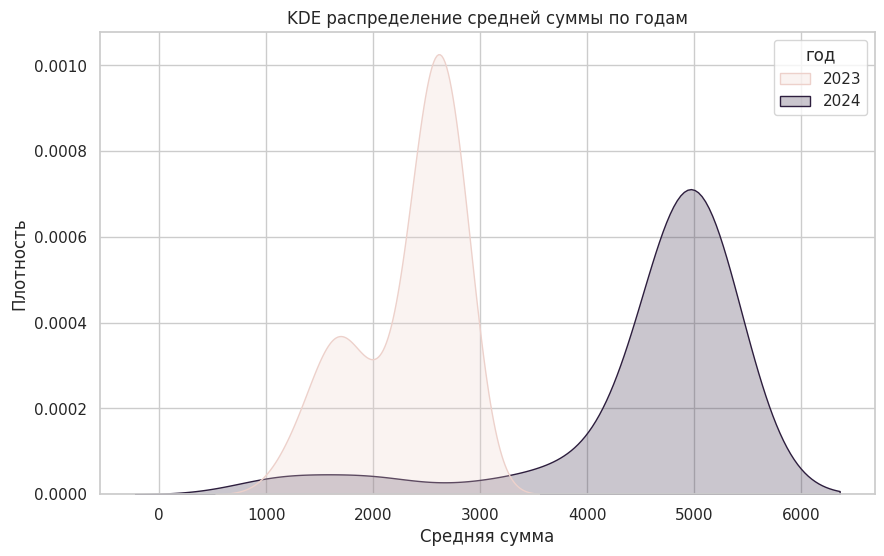

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=org_min_price, x='средняя_сумма', hue='год', fill=True, common_norm=False)
plt.title('KDE распределение средней суммы по годам')
plt.xlabel('Средняя сумма')
plt.ylabel('Плотность')
plt.show()

In [ ]:
top = org_min_price[['инн_организации', 'количество_сделок', 'максимальная_сумма', 'год']]
top['инн_организации'] = top['инн_организации'].astype('str')
top_10_inn = top.groupby('год').apply(lambda x: x.nsmallest(10, 'максимальная_сумма')).reset_index(drop=True)

fig = px.bar(top_10_inn, x='инн_организации', y='максимальная_сумма', color='год', barmode='group',
             title='ТОП-10 ИНН с самым низким "максимальная_сумма" для каждого года',
             labels={'инн_организации': 'ИНН организации', 'максимальная_сумма': 'Максимальная сумма', 'год': 'Год'},
             text='количество_сделок')

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_title='ИНН организации', yaxis_title='Максимальная сумма', uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [ ]:
org_min_price.to_excel('/content/drive/MyDrive/barnaul_analitic/analitic_product/100_бомжей.xlsx', index=False)

# По видам деятельности

In [ ]:
df_type = result_23_24[result_23_24['максимальная_сумма'] > 1000]
short_names = {
    'Обрабатывающие производства': 'Обрабатывающие производства',
    'Транспортировка и хранение': 'Транспортировка и хранение',
    'Строительство': 'Строительство',
    'Добыча полезных ископаемых': 'Добыча полезных ископаемых',
    'Образование': 'Образование',
    'Сельское, лесное хозяйство, охота, рыболовство и рыбоводство': 'Сельское, лесное хозяйство, охота',
    'Не определено': 'Не определено',
    'Торговля оптовая и розничная; ремонт автотранспортных средств и мотоциклов': 'Торговля оптовая и розничная',
    'Деятельность в области здравоохранения и социальных услуг': 'Здравоохранение, социальные услуги',
    'Водоснабжение; водоотведение, организация сбора и утилизации отходов, деятельность по ликвидации загрязнений': 'Водоснабжение, ликвидация загрязнений',
    'Деятельность административная и сопутствующие дополнительные услуги': 'Деятельность административная',
    'Деятельность профессиональная, научная и техническая': 'Деятельность профессиональная, научная',
    'Деятельность в области культуры, спорта, организации досуга и развлечений': 'Культура, спорт, досуг',
    'Обеспечение электрической энергией, газом и паром; кондиционирование воздуха': 'Обеспечение электроэнергией, газом',
    'Деятельность по операциям с недвижимым имуществом': 'Операции с недвижимым имуществом',
    'Государственное управление и оборона; обязательное социальное обеспечение': 'Государственное управление и оборона',
    'Предоставление прочих видов услуг': 'Предоставление прочих видов услуг',
    'Деятельность в области информации и связи': 'Информация и связи',
    'Деятельность финансовая и страховая': 'Финансы и страхование'
}

In [ ]:
df_type['вид_деятельности'] = df_type['вид_деятельности'].replace(short_names)

agg_metrics = df_type.groupby(['год', 'вид_деятельности']).agg({
    'максимальная_сумма': 'max',
    'средняя_сумма': ['mean', 'median']
}).reset_index()
agg_metrics.columns = ['год', 'вид_деятельности', 'максимальная_сумма', 'средняя_сумма_mean', 'средняя_сумма_median']

metrics = ['максимальная_сумма', 'средняя_сумма_mean', 'средняя_сумма_median']
titles = ['Максимальная сумма', 'Средняя сумма (mean)', 'Средняя сумма (median)']

for metric, title in zip(metrics, titles):
    fig = px.bar(agg_metrics, x='вид_деятельности', y=metric, color='год', barmode='group',
                 title=f'{title} по видам деятельности для 2023 и 2024 годов',
                 labels={'вид_деятельности': 'Вид деятельности', metric: title, 'год': 'Год'})

    fig.update_layout(xaxis_title='Вид деятельности', yaxis_title=title, xaxis_tickangle=-45, height=800)
    fig.show()

# Задача - холодные от марины

In [ ]:
import joblib

In [ ]:
table =pd.read_parquet(f'/content/drive/MyDrive/barnaul_analitic/base/marina_table_price.parquet')
table_nom =pd.read_parquet(f'/content/drive/MyDrive/barnaul_analitic/base/marina_table_price_nomenklatura.parquet')
df_org = joblib.load('/content/drive/MyDrive/barnaul_analitic/base/df_organizations.joblib')

In [ ]:
table_nom['сумма_за_удостоверение'] = table_nom['количество_удостоверений'] * table_nom['цена_за_удостоверение']
data = table.copy()
data_nom = table_nom.copy()
data_nom.dropna(subset=['год_оплаты'], inplace=True)
data_nom['год_оплаты'] = data_nom['год_оплаты'].astype(int)
data_nom['месяц_оплаты'] = data_nom['месяц_оплаты'].astype(int)
a_table = df_org.groupby('расшифровка_оквэд').agg({'оквэд': 'first'}).reset_index()
okved_dict = dict(zip(a_table['расшифровка_оквэд'], a_table['оквэд']))
data_nom['оквэд'] = data_nom['расшифровка_оквэд'].map(okved_dict)
data['оквэд'] = data['расшифровка_оквэд'].map(okved_dict)
data = data[data['оквэд']!= '-']
data_nom = data_nom[data_nom['оквэд']!= '-']
data['бюджет'] = data['оквэд'].apply(lambda x: 1 if x is not None and (x.startswith('85.') or x.startswith('84.') or x.startswith('68.')) else 0)
data_nom['бюджет'] = data_nom['оквэд'].apply(lambda x: 1 if x is not None and (x.startswith('85.') or x.startswith('84.') or x.startswith('68.')) else 0)
data['фио_менеджера'] = data['фио_менеджера'].replace("АЙДОВА МАРИНА ВЛАДИМИРОВНА", "Айдова Марина Владимировна")
price_bye = data[data['решение_об_оплате'] == 'оплачено']
nomenclat_bye = data_nom[data_nom['решение_об_оплате'] == 'оплачено']

In [ ]:
# Список ИНН для поиска
inn_list = [4223038414, 4211022674, 4223059460, 2222835170, 2278002325, 2415004863,
            2415001566, 6439081180, 547006912, 570003606, 548004033, 573015631,
            4101143965, 3812083535, 6501246670, 665000031041, 2253000870,
            7714007163, 2465347249, 5004002329, 2234015912, 270505812364, 2105005786]

# Фильтруем датасет по списку ИНН
filtered_df = data_nom[data_nom['инн_организации'].isin(inn_list)]

In [ ]:
filtered_df

,идентификатор,номер_счета,номенклатура,тип_пакета,количество_удостоверений,цена_за_удостоверение,сумма_за_удостоверение,решение_об_оплате,номер_менеджера,фио_менеджера,инн_организации,наименование_организации,количество_студентов,тип_номенклатуры,код_номенклатуры,наименование_региона,расшифровка_оквэд,вид_деятельности,дата_счета,дата_оплаты,сумма,год_оплаты,месяц_оплаты,оквэд,бюджет
74476,65155910,37965837,145. Отходы,None,1,2500,2500,оплачено,1907,Доля Илья Владимирович,4223059460,"ООО ""ПФ ТРУДАРМЕЙСКАЯ""",1,по направлению,145,Кемеровская область - Кузбасс,Разведение сельскохозяйственной птицы,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2021-08-24,2021-09-09,10000.0,2021,9,01.47,0
74477,65155911,37965837,173. Экология,None,1,2500,2500,оплачено,1907,Доля Илья Владимирович,4223059460,"ООО ""ПФ ТРУДАРМЕЙСКАЯ""",1,по направлению,173,Кемеровская область - Кузбасс,Разведение сельскохозяйственной птицы,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2021-08-24,2021-09-09,10000.0,2021,9,01.47,0
74478,65155912,37965837,154. Пожарная безопасность ответственные,None,1,2500,2500,оплачено,1907,Доля Илья Владимирович,4223059460,"ООО ""ПФ ТРУДАРМЕЙСКАЯ""",1,по направлению,154,Кемеровская область - Кузбасс,Разведение сельскохозяйственной птицы,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2021-08-24,2021-09-09,10000.0,2021,9,01.47,0
74479,65155913,37965837,113. Гражданская оборона организаций,None,1,2500,2500,оплачено,1907,Доля Илья Владимирович,4223059460,"ООО ""ПФ ТРУДАРМЕЙСКАЯ""",1,по направлению,113,Кемеровская область - Кузбасс,Разведение сельскохозяйственной птицы,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2021-08-24,2021-09-09,10000.0,2021,9,01.47,0
81047,32337626,20654042,145. Отходы,None,1,7500,7500,оплачено,1150,Ибраева Алиса Олеговна,2105005786,"ООО ""АГРОФИРМА ИМПЕРИЯ""",1,по направлению,145,Чувашская Республика - Чувашия,Cовмещенное растениеводство и животноводство,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2019-09-30,2019-10-08,15000.0,2019,10,01.50,0
81048,32337627,20654042,173. Экология,None,1,7500,7500,оплачено,1150,Ибраева Алиса Олеговна,2105005786,"ООО ""АГРОФИРМА ИМПЕРИЯ""",1,по направлению,173,Чувашская Республика - Чувашия,Cовмещенное растениеводство и животноводство,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2019-09-30,2019-10-08,15000.0,2019,10,01.50,0
91916,77400254,45012789,137. Обучение эвакуационных комиссий,None,1,0,0,отказ,5421,Кириленко Оксана Юрьевна,2105005786,"ООО ""АГРОФИРМА ИМПЕРИЯ""",1,по направлению,137,Чувашская Республика - Чувашия,Cовмещенное растениеводство и животноводство,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2023-07-21,2023-07-21,0.0,2023,7,01.50,0
91917,77400255,45012789,158. Противопожарный инструктаж,None,1,0,0,отказ,5421,Кириленко Оксана Юрьевна,2105005786,"ООО ""АГРОФИРМА ИМПЕРИЯ""",1,по направлению,158,Чувашская Республика - Чувашия,Cовмещенное растениеводство и животноводство,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2023-07-21,2023-07-21,0.0,2023,7,01.50,0
121139,76936174,44749489,173. Экология,None,1,2800,2800,оплачено,5271,Меркулова Екатерина Владимировна,2415001566,"К(Ф)Х ""ШКЕТ""",1,по направлению,173,Красноярский край,"Выращивание зерновых культур (кроме риса), бобовых культур и семян масличных культур","Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2023-05-15,2023-06-15,14000.0,2023,6,01.11,0
121140,76936175,44749489,113. Гражданская оборона организаций,None,1,2800,2800,оплачено,5271,Меркулова Екатерина Владимировна,2415001566,"К(Ф)Х ""ШКЕТ""",1,по направлению,113,Красноярский край,"Выращивание зерновых культур (кроме риса), бобовых культур и семян масличных культур","Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",2023-05-15,2023-06-15,14000.0,2023,6,01.11,0


In [ ]:
grouped_df = filtered_df.groupby(['инн_организации', 'год_оплаты']).agg(
    количество_продаж=('номер_счета', 'count'),
    количество_удостоверений=('количество_удостоверений', 'sum'),
    сумма=('сумма', 'sum'),
    цена_за_удостоверение_mean=('цена_за_удостоверение', 'mean'),
    решение_об_оплате=('решение_об_оплате', 'first'),
    номер_менеджера=('номер_менеджера', 'first'),
    фио_менеджера=('фио_менеджера', 'first'),
    наименование_организации=('наименование_организации', 'first'),
    тип_номенклатуры=('тип_номенклатуры', 'first'),
    номенклатура=('номенклатура', 'first'),
    наименование_региона=('наименование_региона', 'first'),
    расшифровка_оквэд=('расшифровка_оквэд', 'first'),
    вид_деятельности=('вид_деятельности', 'first'),
    оквэд=('оквэд', 'first'),
    бюджет=('бюджет', 'first')
).reset_index()

In [ ]:
# Замена запятых на точки в столбцах 'расшифровка_оквэд' и 'вид_деятельности'
grouped_df['расшифровка_оквэд'] = grouped_df['расшифровка_оквэд'].str.replace(',', '.')
grouped_df['вид_деятельности'] = grouped_df['вид_деятельности'].str.replace(',', '.')

In [ ]:
grouped_df

,инн_организации,год_оплаты,количество_продаж,количество_удостоверений,сумма,цена_за_удостоверение_mean,решение_об_оплате,номер_менеджера,фио_менеджера,наименование_организации,тип_номенклатуры,номенклатура,наименование_региона,расшифровка_оквэд,вид_деятельности,оквэд,бюджет
0,570003606,2021,1,1,0.0,0.0,отказ,793,Федорченко Ольга Васильевна,"ООО ""ДАГНОТЕХ""",по направлению,173. Экология,Республика Дагестан,Производство нефтепродуктов,Обрабатывающие производства,19.20,0
1,573015631,2021,1,4,31800.0,7950.0,оплачено,793,Федорченко Ольга Васильевна,"ООО ""КАСПЕТРОЛСЕРВИС""",по направлению,145. Отходы,Республика Дагестан,Торговля оптовая твердым. жидким и газообразным топливом и связанными с ним продуктами,Торговля оптовая и розничная; ремонт автотранспортных средств и мотоциклов,46.71,0
2,2105005786,2019,2,2,30000.0,7500.0,оплачено,1150,Ибраева Алиса Олеговна,"ООО ""АГРОФИРМА ИМПЕРИЯ""",по направлению,145. Отходы,Чувашская Республика - Чувашия,Cовмещенное растениеводство и животноводство,Сельское. лесное хозяйство. охота. рыболовство и рыбоводство,01.50,0
3,2105005786,2022,2,6,34800.0,2900.0,оплачено,1164,Павлова Юлия Валерьевна,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АГРОФИРМА ИМПЕРИЯ""",по направлению,135. Обучение по охране труда,Чувашская Республика - Чувашия,Cовмещенное растениеводство и животноводство,Сельское. лесное хозяйство. охота. рыболовство и рыбоводство,01.50,0
4,2105005786,2023,2,2,0.0,0.0,отказ,5421,Кириленко Оксана Юрьевна,"ООО ""АГРОФИРМА ИМПЕРИЯ""",по направлению,137. Обучение эвакуационных комиссий,Чувашская Республика - Чувашия,Cовмещенное растениеводство и животноводство,Сельское. лесное хозяйство. охота. рыболовство и рыбоводство,01.50,0
5,2278002325,2020,5,6,37400.0,3740.0,отказ,1682,Щепетной Рашид Санан оглы,СПК «Заря»,по направлению,173. Экология,Алтайский край,Cовмещенное растениеводство и животноводство,Сельское. лесное хозяйство. охота. рыболовство и рыбоводство,01.50,0
6,2278002325,2022,8,15,59860.0,1415.0,оплачено,1016,Мосина Светлана Евгеньевна,СЕЛЬСКОХОЗЯЙСТВЕННЫЙ ПРОИЗВОДСТВЕННЫЙ КООПЕРАТИВ ЗАРЯ,по направлению,135. Обучение по охране труда,Алтайский край,Cовмещенное растениеводство и животноводство,Сельское. лесное хозяйство. охота. рыболовство и рыбоводство,01.50,0
7,2415001566,2023,5,5,70000.0,2800.0,оплачено,5271,Меркулова Екатерина Владимировна,"К(Ф)Х ""ШКЕТ""",по направлению,173. Экология,Красноярский край,Выращивание зерновых культур (кроме риса). бобовых культур и семян масличных культур,Сельское. лесное хозяйство. охота. рыболовство и рыбоводство,01.11,0
8,4223038414,2019,1,1,3900.0,3900.0,оплачено,964,Саломатова Наталья Ивановна,"ООО ""СХП ""МИХАЙЛОВСКОЕ""",по направлению,111. ГО И ЧС,Кемеровская область - Кузбасс,Cовмещенное растениеводство и животноводство,Сельское. лесное хозяйство. охота. рыболовство и рыбоводство,01.50,0
9,4223038414,2020,1,1,1060.0,1060.0,оплачено,964,Саломатова Наталья Ивановна,"ООО ""СХП ""МИХАЙЛОВСКОЕ""",по направлению,125. Медицинская помощь,Кемеровская область - Кузбасс,Cовмещенное растениеводство и животноводство,Сельское. лесное хозяйство. охота. рыболовство и рыбоводство,01.50,0


In [ ]:
table = joblib.load('/content/drive/MyDrive/barnaul_analitic/base/df_organizations_all.joblib')

In [ ]:
table.head(1)

,org_id,inn,ogrn,дата_регистрации,уставный_капитал,количество_работников,выручка,предыдущие_руководители,учредители,дочерние_организации,...,сумма_ответственных,количество_ответственных,сумма_источников,количество_источников,сумма_контрактов,количество_контрактов,сумма_закупок,количество_закупок,рейтинг,польза
0,6623978,100000050,1020100001899,1992-07-29,13200000.0,8,0,не установлен,не установлен,не установлен,...,0,0,0,0,0,0,0,0,4,0


In [ ]:
# Список ИНН для поиска
inn_list = [4223038414, 4211022674, 4223059460, 2222835170, 2278002325, 2415004863,
            2415001566, 6439081180, 547006912, 570003606, 548004033, 573015631,
            4101143965, 3812083535, 6501246670, 665000031041, 2253000870,
            7714007163, 2465347249, 5004002329, 2234015912, 270505812364, 2105005786]

In [ ]:
# Фильтруем датасет по списку ИНН
filtered_org = table[table['inn'].isin(inn_list)]

In [ ]:
filtered_org

,org_id,inn,ogrn,дата_регистрации,уставный_капитал,количество_работников,выручка,предыдущие_руководители,учредители,дочерние_организации,телефон,руководитель,должность_руководителя,наименование_организации,электронная_почта,код_региона,наименование_региона,оквэд,расшифровка_оквэд,вид_деятельности,сумма_исполнителей,количество_исполнителей,сумма_ответственных,количество_ответственных,сумма_источников,количество_источников,сумма_контрактов,количество_контрактов,сумма_закупок,количество_закупок,рейтинг,польза
20022,92252,547006912,1060547001426,NaT,182.0,30,27,не установлен,не установлен,не установлен,NaN,не установлен,не установлен,"ооо ""дагнефтепродукт""",не установлен,5,Республика Дагестан,19.20,Производство нефтепродуктов,Обрабатывающие производства,0,0,0,0,0,0,0,0,0,0,0,0
20075,0,548004033,0,NaT,20000.0,4,0,не установлен,не установлен,не установлен,NaN,не установлен,не установлен,не установлен,не установлен,0,не установлен,не установлен,не установлен,не установлен,0,0,0,0,0,0,0,0,0,0,0,0
20767,6647855,570003606,1100570003203,2010-10-19,720300000.0,73,56628,"Генеральный директор Мамедов Енгибар Шираслан Оглы\n20.12.2010\n\nГенеральный директор Магомедов Юсуп Магомедович\n26.02.2014\n\nГенеральный директор Алибеков Вагиф Исфендиярович\n\nГенеральный директор Мурзаев Карамутдин Изиевич, ИНН 056002765537\n22.03.2016\n\nГенеральный директор Мугаджиров Наврузбек Расулович, ИНН 052201567324\n13.07.2017\n\nГенеральный директор Гайдаров Магомеднаби Садыкович, ИНН 056101339956\n07.12.2021\n\nГенеральный директор Абдулаев Шамсул Абдуллаевич, ИНН 056102960901\n12.10.2022\n",не установлен,не установлен,7.963422e+10,Гамзатов Махач Газимагомедович,Генеральный директор,"общество с ограниченной ответственностью ""дагестанские новые технологии""",не установлен,5,Республика Дагестан,19.20,Производство нефтепродуктов,Обрабатывающие производства,2,1,0,0,0,0,0,0,0,0,0,0
21124,5486651,573015631,1210500007035,2021-05-21,313648000.0,565,651567,"Генеральный директор Мурзаев Карамутдин Изиевич, ИНН 056002765537\n21.05.2021\n",не установлен,"ООО ""Нефтепродуктснаб""\n\nООО ""Центр спортивной медицины и реабилитации""\n",7.938205e+10,Гайдаров Магомеднаби Садыкович,Генеральный директор,"ооо ""каспетролсервис""",eco.marina@mail.ru,5,Республика Дагестан,46.71,"Торговля оптовая твердым, жидким и газообразным топливом и связанными с ним продуктами",Торговля оптовая и розничная; ремонт автотранспортных средств и мотоциклов,13,16,0,0,0,0,0,0,0,0,0,1
112039,189644,2105005786,1132133000130,2013-05-14,10000.0,15,39120,не установлен,не установлен,не установлен,7.953011e+10,Курников Андрей Валерьевич,Генеральный директор,"ооо ""агрофирма империя""",88353821849@mail.ru,21,Чувашская Республика - Чувашия,01.50,Cовмещенное растениеводство и животноводство,"Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",0,0,0,0,0,0,0,0,0,0,0,2
123768,0,2222835170,1152223006297,2015-04-17,10000.0,13,139666,не установлен,не установлен,не установлен,7.913240e+10,Рябов Александр Валерьевич,Директор,не установлен,не установлен,0,не установлен,не установлен,не установлен,не установлен,0,0,0,0,0,0,0,0,0,0,0,0
128041,6365862,2234015912,1202200010869,2020-03-31,100000.0,25,260860,"Генеральный директор Митин Валерий Валерьевич, ИНН 773607918136\n31.03.2020\n",не установлен,не установлен,NaN,Бурсов Владимир Николаевич,Генеральный директор,"общество с ограниченной ответственностью ""сростки""",не установлен,22,Алтайский край,01.11,"Выращивание зерновых культур (кроме риса), бобовых культур и семян масличных культур","Сельское, лесное хозяйство, охота, рыболовство и рыбоводство",0,0,0,0,0,0,0,0,0,0,4,0
129052,6391152,2253000870,1022202238080,2001-06-18,0.0,1,153,"Генеральный директор Чернов Владимир Алексеевич, ИНН 225300446273\n10.09.2002\n\nГенеральный директор Боженко Евгения Сергеевна, ИНН 225302963284\n07.06.2016\n\nГенеральный директор Кокшенёв Сергей Александрович, ИНН 221101297012\n15.09.2020\n",не установлен,"ОАО ""Алтайагростройконструкция""\n",7.906946e+10,Власова Татьяна 

In [ ]:
filtered_org.to_excel('/content/drive/MyDrive/barnaul_analitic/analitic_product/cooll_org_2024.xlsx', index=False)